# Model Evaluation the Stroke Prediction problem

## Loading data set and model

First of all, the necessary modules to deal with the problem's data is loaded and the dataset is read. 

In [33]:
# Third-party imports
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("./.matplotlib/matplotlibrc.bin")
import numpy as np
from pathlib import Path

import yaml
import joblib
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
# Inline plotting for Jupyter
%matplotlib inline

# Local application imports
from stroke_predictor.utils.preprocessing import preprocess_dataframe
from stroke_predictor.utils.data_io import load_model_and_config
from stroke_predictor.utils.models import PatientFeatures
from stroke_predictor.utils.predictor import make_prediction
from stroke_predictor.utils.data_io import load_dataset


The data set can be read from the paths available at the configuration file with the details of the model.

In [34]:
config_path = "./models/stroke_predictor_optuna/model_config.yml"

with open(config_path, "r") as f:
        config = yaml.safe_load(f)

global_config = config["global"]
data_config = config["storage"]

# Load data
X, y = load_dataset(
        path=Path(data_config["data_path"]),
        key=data_config["hdf5_key_test"],
        target=data_config["target"],
)

Load the MLflow model and the configuration.

In [35]:
# Load the MLflow model and configuration
MODEL_PATH = "./models/stroke_predictor_optuna"
model, _, column_names, variable_encoder = load_model_and_config(MODEL_PATH)

As the data was scaled before training the model, the same scaler that was fitted with the training data is used to scale the testing data.

In [36]:
input_data = pd.DataFrame(X, columns=column_names)
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1533 non-null   float64
 1   age                1533 non-null   float64
 2   hypertension       1533 non-null   float64
 3   heart_disease      1533 non-null   float64
 4   ever_married       1533 non-null   float64
 5   work_type          1533 non-null   float64
 6   Residence_type     1533 non-null   float64
 7   avg_glucose_level  1533 non-null   float64
 8   bmi                1533 non-null   float64
 9   smoking_status     1533 non-null   float64
 10  bmi_category       1533 non-null   float64
 11  age_group          1533 non-null   float64
 12  glucose_category   1533 non-null   float64
 13  health_score       1533 non-null   float64
 14  risk_category      1533 non-null   float64
dtypes: float64(15)
memory usage: 179.8 KB


### Results and Model Evaluation

The loaded model can be now used to predict the scaled testing data and perform evaluations.

In [37]:
# Preprocess the input data
y_pred = model.predict(X)
y_pred_probability = model.predict_proba(X)[:, 1]

We can use the confusion matrix to see the amount of times the network made a mistake on the classification.

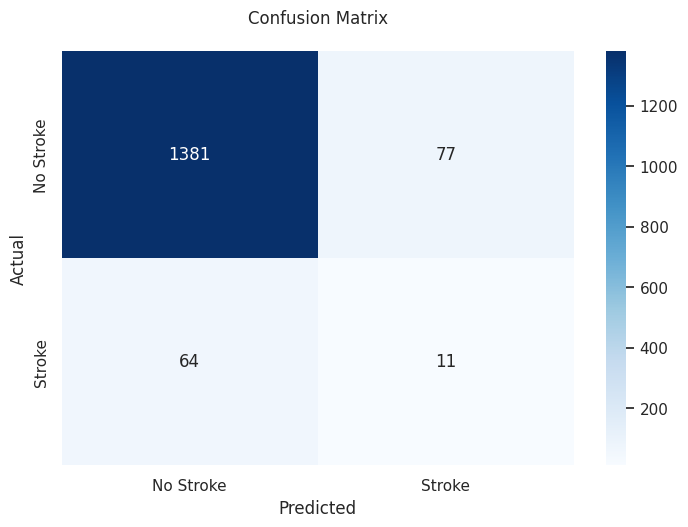

In [38]:
# Confusion matrix
cm = confusion_matrix(y, y_pred)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Stroke", "Stroke"],
            yticklabels=["No Stroke", "Stroke"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("./imgs/evaluation/confusion_matrix.pdf")

From the confusion matrix, it could be seen that while the model is quite accurate in identifying patients who will not suffer the stroke, it struggles with the positive cases. This reflects the complex nature of the dataset, where most of the samples are negative. 

This result shows that, even when balancing the dataset using SMOTE, the models potentially struggle generalizing data from the minority class, mainly because the data is not enough for the model to learn how to identify such events.

We can also evaluate the model with other metrics relevant for imbalanced classification: precision, recall, and f1-score.

In [39]:
# Compute the metrics relevant for classification
report = classification_report(y, y_pred, target_names=["No Stroke", "Stroke"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
No Stroke,0.955709,0.947188,0.951430,1458.000000
Stroke,0.125000,0.146667,0.134969,75.000000
accuracy,0.908023,0.908023,0.908023,0.908023
macro avg,0.540355,0.546927,0.543199,1533.000000
weighted avg,0.915068,0.908023,0.911485,1533.000000


Out of 1533 samples, the model correctly classified the majority of non-stroke cases, achieving an overall **accuracy of 90.15%**. However, its performance on the minority class (stroke) was significantly limited.

These results indicate that while the model is effective at identifying non-stroke individuals, it fails to reliably detect stroke cases. The low recall for the stroke class means that most actual stroke cases are missed (only 11 out of 75 correctly identified), and the low precision implies that many of the stroke predictions are false positives.

This imbalance is a known challenge in medical classification tasks where positive cases are rare. Even though SMOTE was used to synthetically balance the dataset during training, the model remains biased toward the majority class. Future improvements could include enhanced resampling strategies, cost-sensitive learning, or specialized architectures better suited for imbalanced data.

We can also use the probability achieved by the model to check the output of the MLP.

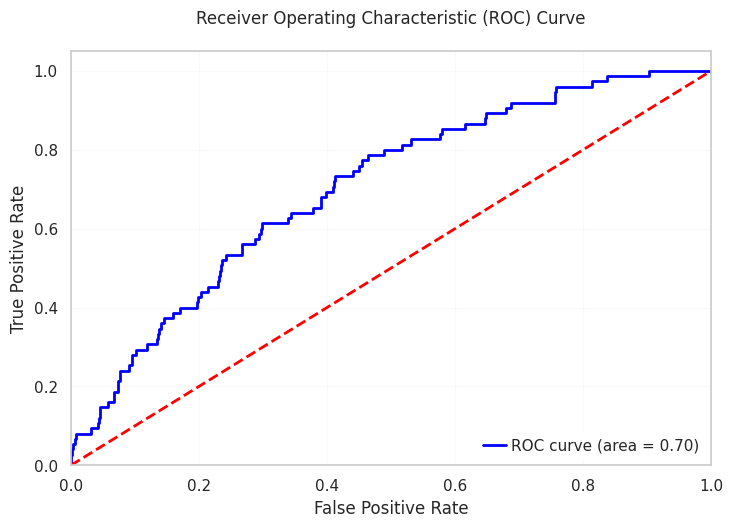

In [40]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_probability)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig("./imgs/evaluation/roc_curve.pdf")

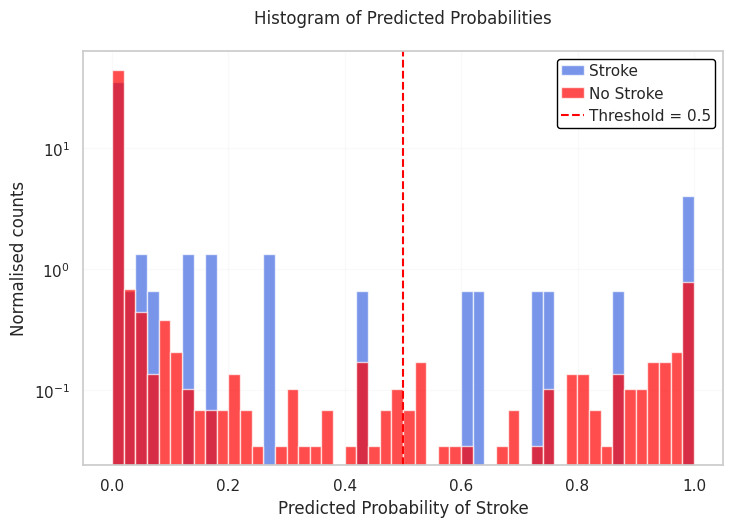

In [41]:
# Histogram of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_pred_probability[y==1], bins=50, color='royalblue', alpha=0.7, density=True, label='Stroke')
plt.hist(y_pred_probability[y==0], bins=50, color='red', alpha=0.7, density=True, label='No Stroke')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Stroke')
plt.ylabel('Normalised counts')
# Log scaled y
plt.yscale('log')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.legend(edgecolor='black', facecolor='white')
plt.savefig("./imgs/evaluation/predicted_probabilities_histogram.pdf")

The model achieved an Area Under the Receiver Operating Characteristic Curve (AUC-ROC) of 0.71, indicating moderate ability to discriminate between stroke and non-stroke cases.

## Conclusions

A supervised classification model was developed to predict the risk of stroke based on patient features, using a variety of machine learning algorithms and systematic hyperparameter optimization.

To address the class imbalance in the dataset, the Synthetic Minority Over-sampling Technique (SMOTE) was applied during training. The F1-score was chosen as the optimization metric due to its suitability for imbalanced datasets, as it balances precision and recall.

The best-performing model was a Multi-layer Perceptron (MLP) with three hidden layers and tuned regularization. Its performance was evaluated using a confusion matrix and classification metrics. These results highlight that the model performs very well on the majority class but struggles with detecting stroke cases, which are rare. Despite oversampling, many stroke cases are still missed (low recall), and most stroke predictions are incorrect (low precision).

Although the system is functional and accessible, further work is needed to improve the sensitivity of the model to stroke cases before deployment in critical clinical environments. Future improvements may include ensemble methods, cost-sensitive training, or leveraging additional patient history features.